# List of topics for the final project



## Project 5 algorithmic fairness
Algorithm fairness is becoming a fundamental topic in ML. It is a complex ethical task to define what fairness is/means. Once we have defined quantitatively what fairness is then, from a mathematical perspective, the problem of  algorithmic fairness is very clear: it is a multi-objective optimization problem. There are multi objectives that we aim to optimize during data fitting, e.g., accuracy and fairness.

The goal of this project is to implement from scratch the "fair" **linear and nonlinear SVM** described in the following paper (see in particular Appendix A that reports the optimization problem)  

["Fairness Constraints: Mechanisms for Fair Classification"](https://arxiv.org/pdf/1507.05259.pdf)

and reproduce the experiments reported in the paper. In particular, apply your method to the Adult and Bank 
data sets.

Your notebook must include:
* a description (summary) of the algorithm presented in the above paper (focusing on SVM), similar to the theoretical details of logistic regression I wrote at the beginning of the notebook for e-tivity Task A (week 1&2). The reader must understand from your explanation the difference between standard SVM and the "fair" SVM.
* You implementation of the "fair" **linear and nonlinear SVM** using CVXOPT to solve data fitting (as I have shown in Week 3 webinar, see also example below). You should implement it as a Python class (similar to logistic regression class for E-tivity 1).
* A test of the input-output behavior of your algorithm. More clearly, you have to replicate the experiment results you find in Section 4.1 for Synthetic Data and Section 4.2 of the above paper for the Adult and Bank data sets.


Resources:
* Week 3 webinar slides with the details of the SVM algorithm;
* [Example](https://xavierbourretsicotte.github.io/SVM_implementation.html) about how to use the library CVXOPT to implement data fitting for standard SVM
* [fairness-in-machine-learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)
* (Optional) Multi-objective optimization and Pareto optimality see Book chapter 12 (of our Module's book).

**How to approach the problem** (this is just a suggestion).

You can start implementing linear SVM and apply it to the Synthetic Data experiment in Section 4.1 so that you can plot the classification line for standard linear SVM versus fair linear SVM.


In [11]:
import numpy as np
from sklearn import datasets

# Import helper functions
from mlfromscratch.utils import train_test_split, normalize, accuracy_score, Plot
from mlfromscratch.utils.kernels import *
from mlfromscratch.supervised_learning import SupportVectorMachine

In [12]:
from __future__ import division, print_function
import numpy as np
import cvxopt
from mlfromscratch.utils import train_test_split, normalize, accuracy_score
from mlfromscratch.utils.kernels import *
from mlfromscratch.utils import Plot

# Hide cvxopt output
cvxopt.solvers.options['show_progress'] = False

class SupportVectorMachine(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.

    Parameters:
    -----------
    C: float
        Penalty term.
    kernel: function
        Kernel function. Can be either polynomial, rbf or linear.
    power: int
        The degree of the polynomial kernel. Will be ignored by the other
        kernel functions.
    gamma: float
        Used in the rbf kernel function.
    coef: float
        Bias term used in the polynomial kernel function.
    """
    def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):

        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        # Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])

        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        idx = lagr_mult > 1e-7
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]

        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)


Accuracy: 0.8181818181818182


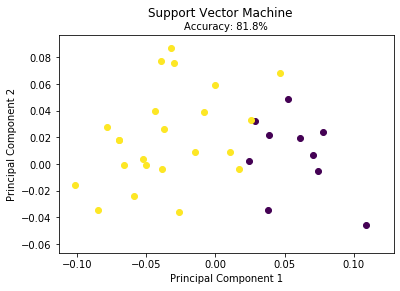

In [13]:
data = datasets.load_iris()
X = normalize(data.data[data.target != 0])
y = data.target[data.target != 0]
y[y == 1] = -1
y[y == 2] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = SupportVectorMachine(kernel=polynomial_kernel, power=4, coef=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

# Reduce dimension to two using PCA and plot the results
Plot().plot_in_2d(X_test, y_pred, title="Support Vector Machine", accuracy=accuracy)

